# Setup
## Install Dependencies

In [1]:
#!pip install tensorflow opencv-python matplotlib

## Importing Dependencies

In [1]:
# importing standard dependencies
import re
import uuid
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# importing tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# ONLY FOR GPUs - to avoid running out of memory error
'''
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
'''

'\ngpus = tf.config.experimental.list_physical_devices("GPU")\nfor gpu in gpus:\n    tf.config.experimental.set_memory_growth(gpu, True)\n'

## Folder structure

In [4]:
# setting up paths
POSITIVE_PATH = os.path.join('data','positive') # data/positive
NEGATIVE_PATH = os.path.join('data','negative') # data/negative
ANCHOR_PATH = os.path.join('data','anchor') # data/anchor

In [5]:
'''
# making directories
os.makedirs(POSITIVE_PATH)
os.makedirs(NEGATIVE_PATH)
os.makedirs(ANCHOR_PATH)
'''

'\n# making directories\nos.makedirs(POSITIVE_PATH)\nos.makedirs(NEGATIVE_PATH)\nos.makedirs(ANCHOR_PATH)\n'

# Collect Positive and Anchors

## Unzip _Labelled Faces in the Wild_ dataset

In [6]:
# Link to Dataset
# http://vis-www.cs.umass.edu/lfw/#download

In [7]:
# Uncompressing the dataset
#!tar -xf lfw.tgz

In [8]:
'''
# moving images to data/negative folder
pattern = r".*Icon.*"
for directory in os.listdir('lfw'):
    if re.match(pattern, directory):
        print(directory)
        continue
    for file in os.listdir(os.path.join('lfw',directory)):
        if re.match(pattern, file):
            print(file)
            continue
        else:
            EXISTING_PATH = os.path.join('lfw', directory, file)
            NEW_PATH = os.path.join(NEGATIVE_PATH, file)
            os.replace(EXISTING_PATH, NEW_PATH)
'''

'\n# moving images to data/negative folder\npattern = r".*Icon.*"\nfor directory in os.listdir(\'lfw\'):\n    if re.match(pattern, directory):\n        print(directory)\n        continue\n    for file in os.listdir(os.path.join(\'lfw\',directory)):\n        if re.match(pattern, file):\n            print(file)\n            continue\n        else:\n            EXISTING_PATH = os.path.join(\'lfw\', directory, file)\n            NEW_PATH = os.path.join(NEGATIVE_PATH, file)\n            os.replace(EXISTING_PATH, NEW_PATH)\n'

## Collect Positive and Anchor classes

In [15]:
'''
cap = cv2.VideoCapture(0)
while cap.isOpened():
    # Set the capture resolution to 250x250
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 250)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 250)
    
    ret, frame = cap.read()
    cv2.imshow('Webcam',frame)
    
    # resizing the image
    frame = cv2.resize(frame, (250,250))
    # collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANCHOR_PATH,f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, frame)
    
    # collecting positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POSITIVE_PATH,f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, frame)
        
    # break
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# release the webcam
cap.release()

# close the image show frame
cv2.destroyAllWindows()
for i in range (1,5):
    cv2.waitKey(1)
'''

"\ncap = cv2.VideoCapture(0)\nwhile cap.isOpened():\n    # Set the capture resolution to 250x250\n    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 250)\n    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 250)\n    \n    ret, frame = cap.read()\n    cv2.imshow('Webcam',frame)\n    \n    # resizing the image\n    frame = cv2.resize(frame, (250,250))\n    # collecting anchors\n    if cv2.waitKey(1) & 0XFF == ord('a'):\n        imgname = os.path.join(ANCHOR_PATH,f'{uuid.uuid1()}.jpg')\n        cv2.imwrite(imgname, frame)\n    \n    # collecting positives\n    if cv2.waitKey(1) & 0XFF == ord('p'):\n        imgname = os.path.join(POSITIVE_PATH,f'{uuid.uuid1()}.jpg')\n        cv2.imwrite(imgname, frame)\n        \n    # break\n    if cv2.waitKey(1) & 0XFF == ord('q'):\n        break\n# release the webcam\ncap.release()\n\n# close the image show frame\ncv2.destroyAllWindows()\nfor i in range (1,5):\n    cv2.waitKey(1)\n"

In [16]:
# print(frame.shape)
# plt.imshow(frame)

# Load & Preprocess Images

## Get Image Directories

In [17]:
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+"/*.jpg").take(300)
positive = tf.data.Dataset.list_files(POSITIVE_PATH+"/*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH+"/*.jpg").take(300)

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
dir_test.next()

b'data/anchor/9ff04784-650d-11ee-ad10-029712aa94fc.jpg'

## Preprocessing - Scale & Resize

In [20]:
def preprocess(file_path):
    
    # reading image from file path
    byte_img = tf.io.read_file(file_path)
    
    # loading the image
    img = tf.io.decode_jpeg(byte_img)
    
    # resizing the image
    img = tf.image.resize(img,(105,105))
    
    # scalling the values of the image
    img = img / 255.0

    # returning image
    return img

## Create Labelled Dataset

In [21]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [24]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024) # shuffling the dataset

In [25]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

## Build train and test partitions

In [26]:
# training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16) # processing in batches of 16 images
train_data = train_data.prefetch(8) # preprocess the next 8 images

In [27]:
# testing partition
test_data = data.skip(round(len(data)*0.7)) # skipping the first 70% of the data
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Creation

## Building embedding layer

In [28]:
def embedding():
    # input layer
    inp = Input(shape=(105,105,3), name="input_image")

    # block-1
    conv1 = Conv2D(64, (10,10), activation='relu')(inp)
    maxPool1 = MaxPooling2D(64, (2,2), padding='same')(conv1)

    # block-2
    conv2 = Conv2D(128, (7,7), activation='relu')(maxPool1)
    maxPool2 = MaxPooling2D(64, (2,2), padding='same')(conv2)

    # block-3
    conv3 = Conv2D(128, (4,4), activation='relu')(maxPool2)
    maxPool3 = MaxPooling2D(64, (2,2), padding='same')(conv3)
    
    # block-4
    conv4 = Conv2D(256, (4,4), activation='relu')(maxPool3)
    flatten1 = Flatten()(conv4)
    fullyConn = Dense(4096, activation='sigmoid')(flatten1)

    return Model(inputs=[inp],outputs=[fullyConn],name='embedding')

In [29]:
embedding = embedding()

In [30]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## Build L1 - Distance Layer

In [31]:
class L1Distance(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Building Siamese Model

In [32]:
def build_siamese_model():
    # anchor image input
    input_image = Input(shape=(105,105,3), name="input_img")
    
    # validation image input
    validation_image = Input(shape=(105,105,3), name="validation_img")
    
    # combining embedded layer and L1 distance layer
    siamese_layer = L1Distance()
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # classifier
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier, name="SiameseModel")

In [33]:
siamese_model = build_siamese_model()

In [34]:
siamese_model.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                       

# Training the Model

## Setting up loss and optimizer

In [35]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [36]:
optimizer = tf.optimizers.legacy.Adam(learning_rate=0.0001)

## Establishing checkpoints

In [37]:
'''
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)
'''

"\ncheckpoint_dir = './training_checkpoints'\ncheckpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')\ncheckpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)\n"

## Building train step function

In [38]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # anchor and positive/negative image
        X = batch[:2]
        # label
        y = batch[2]
        
        # forward pass
        yhat = siamese_model(X, training=True)
        
        # calc loss
        loss = binary_cross_loss(y,yhat)

    # calc gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # calc updated weights and apply to model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

## Building training loop

In [39]:
def train(data, epochs):
    for epoch in range(epochs):
        print(f'\n Epoch {epoch+1}/{epochs}')
        progress_bar = tf.keras.utils.Progbar(len(data))
        
        # looping through each batch
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progress_bar.update(idx+1)
        print(f'loss: {loss}')
        '''
        # saving the checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        '''

## Training the Model

In [40]:
epochs = 20

In [36]:
# training the model
# train(train_data, epochs)


 Epoch 1/20


2023-10-07 22:23:06.764302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/27 [===========================>..] - ETA: 0s

2023-10-07 22:23:30.111166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 28s 926ms/step
loss: 0.2496415674686432

 Epoch 2/20
27/27 [==============================] - 21s 818ms/step
loss: 0.02268999256193638

 Epoch 3/20
27/27 [==============================] - 21s 818ms/step
loss: 0.015812359750270844

 Epoch 4/20
27/27 [==============================] - 21s 822ms/step
loss: 6.716353527735919e-05

 Epoch 5/20
27/27 [==============================] - 21s 818ms/step
loss: 7.331466349569382e-06

 Epoch 6/20
27/27 [==============================] - 21s 818ms/step
loss: 2.034044882748276e-05

 Epoch 7/20
27/27 [==============================] - 21s 818ms/step
loss: 4.1696723201312125e-05

 Epoch 8/20
27/27 [==============================] - 21s 818ms/step
loss: 0.00029132896452210844

 Epoch 9/20
27/27 [==============================] - 21s 819ms/step
loss: 1.1920930376163597e-07

 Epoch 10/20
27/27 [==============================] - 21s 818ms/step
loss: 0.0001655343803577125

 Epoch 11/20
27/27 [========================

# Evaluating the Model

## Import Metrics

In [41]:
from tensorflow.keras.metrics import Precision, Recall

## Calculating metrics

In [42]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [39]:
# making predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

2023-10-07 22:30:02.388784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 619ms/step


array([[8.3059938e-08],
       [2.1181537e-09],
       [2.3166085e-09],
       [4.6239397e-06],
       [9.9998403e-01],
       [9.9999762e-01],
       [9.9999905e-01],
       [9.9999976e-01],
       [9.9999964e-01],
       [6.4615833e-06],
       [4.6857448e-08],
       [9.9999976e-01],
       [1.1962224e-05],
       [9.9999988e-01],
       [9.9999988e-01],
       [9.9999964e-01]], dtype=float32)

In [40]:
res = [1 if prediction > 0.5 else 0 for prediction in y_hat]
print(res)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]


In [41]:
m = Recall()

# calc recall
m.update_state(y_true, y_hat)

# return recall result
print(f'Recall: {m.result().numpy()}')

Recall: 1.0


In [42]:
m = Precision()

# calc recall
m.update_state(y_true, y_hat)

# return recall result
print(f'Precision: {m.result().numpy()}')

Precision: 1.0


## Visualing results

Result: Not Matched


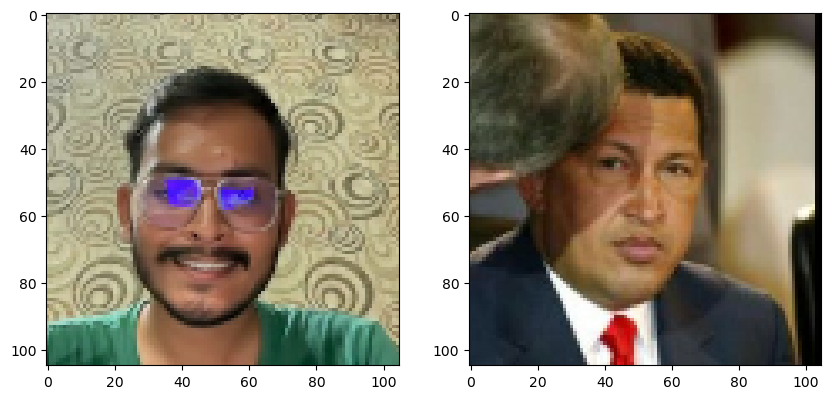

In [43]:
index = 1

if(res[index]==0):
    print("Result: Not Matched")
else:
    print("Result: Matched")

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[index])
plt.subplot(1,2,2)
plt.imshow(test_val[index])
plt.show()

Result: Matched


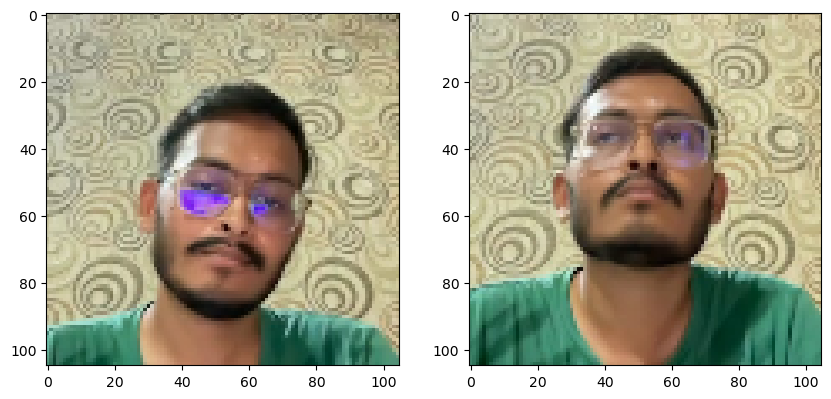

In [49]:
index = 5

if(res[index]==0):
    print("Result: Not Matched")
else:
    print("Result: Matched")

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[index])
plt.subplot(1,2,2)
plt.imshow(test_val[index])
plt.show()

# Saving the Model

In [44]:
# saving weights
# siamese_model.save("siamese_model.h5")

/Users/yash1010/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
# reload model
model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Distance':L1Distance, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [46]:
# predicting using reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 17ms/step
